In [1]:
import numpy
import numpy as np
import os

# Base path where your data resides, relative to your code directory
base_data_path = os.path.join("..", "data")

# Define file names
decode_input_file = "decode_input.txt"
train_struct_file = "train_struct.txt"
model_file = "model.txt"
train_data_file = "train.txt"
test_data_file = "test.txt"
parameter_file = "Parameters"
solution_file = "solution.txt"

# Build full paths by appending file names to the base data path
decode_input_path = os.path.join(base_data_path, decode_input_file)
train_struct_path = os.path.join(base_data_path, train_struct_file)
model_path = os.path.join(base_data_path, model_file)
train_data_path = os.path.join(base_data_path, train_data_file)
test_data_path = os.path.join(base_data_path, test_data_file)
parameter_path = os.path.join("..", "results", parameter_file)
solution_path = os.path.join("..", "results", solution_file)

# Now you can use these paths in your code
print("File paths:")
print("Decode input path:", decode_input_path)
print("Train struct path:", train_struct_path)
print("Model path:", model_path)
print("Train data path:", train_data_path)
print("Test data path:", test_data_path)
print("Parameter file path:", parameter_path)
print("Solution file path:", solution_path)



def read_decode_input(file_path = decode_input_path):
    """
    Reads the decode_input data from the file.
    Each line represents one letter with 128 elements.
    There are 26 weight vectors each with 128 elements and a transition matrix T with size 26x26.
    The transition matrix T is in row-major order.
    """
    with open(file_path, "r") as f:
        raw_data = f.read().split("\n")

    X = np.array(raw_data[:100 * 128], dtype=float).reshape(100, 128)
    W = np.array(raw_data[100 * 128:100 * 128 + 26 * 128], dtype=float).reshape(26, 128)
    T = np.array(raw_data[100 * 128 + 26 * 128:-1], dtype=float).reshape(26, 26)
    T = np.swapaxes(T, 0, 1)
    
    print("Shapes of decode input:")
    print("X:", X.shape, "W:", W.shape, "T:", T.shape)
    #print("Top 5 rows of X:\n", X[:5])

    return X, W, T

def read_train_struct(file_path = train_struct_path):
    """
    Reads the train_struct data from the file.
    Each line represents a label and a feature vector (in a sparse representation).
    """
    with open(file_path, "r") as f:
        raw_data = f.read().split("\n")

    dataX, dataY = [], []
    for line in raw_data[:-1]:  # The last element is empty
        line = line.split(" ")
        dataY.append([int(line[0]) - 1, int(line[1][4:])])
        datax = np.zeros(128, dtype=int)
        for f1 in line[2:]:
            idx, val = f1.split(":")
            datax[int(idx) - 1] = int(val)
        dataX.append(datax)
    
    dataX_np = np.array(dataX, dtype=int)
    print("Shapes of train_struct:")
    print("dataX:", dataX_np.shape, "dataY length:", len(dataY))
    #print("Top 5 rows of dataX:\n", dataX_np[:5])
    
    return dataX_np, dataY

def read_model(file_path = model_path):
    """
    Reads the model data from the file.
    The data consists of weight vectors for each label and a transition matrix T.
    """
    with open(file_path, "r") as f:
        raw_data = f.read().split("\n")

    W = np.array(raw_data[:26 * 128], dtype=float).reshape(26, 128)
    T = np.array(raw_data[26 * 128:-1], dtype=float).reshape(26, 26)
    T = np.swapaxes(T, 0, 1)
    
    print("Shapes of model data:")
    print("W:", W.shape, "T:", T.shape)
    #print("Top 5 rows of W:\n", W[:5])
    
    return W, T

def read_train(file_path = train_data_path):
    """
    Reads the train data from the file.
    Each row corresponds to an example and is split into the label and the feature vector.
    """
    from string import ascii_lowercase
    mapping = {letter: idx for idx, letter in enumerate(ascii_lowercase)}

    with open(file_path, "r") as f:
        raw_data = f.read().split("\n")

    dataX, dataY = [], []
    tempX, tempY = [], []
    for row in raw_data[:-1]:
        row = row.split(" ")
        tempY.append(mapping[row[1]])
        tempX.append(np.array(row[5:], dtype=float))
        if int(row[2]) < 0:  # End of sequence
            dataX.append(np.array(tempX))
            dataY.append(np.array(tempY, dtype=int))
            tempX, tempY = [], []  # Reset for the next sequence

    print("Number of training sequences:", len(dataX))
    print("First 5 sequences' labels:\n", dataY[:5])
    
    return list(zip(dataX, dataY))

import numpy as np

def read_test(file_path = test_data_path):
    """
    Reads the test data from the file.
    Each row corresponds to an example and is split into the label and the feature vector.
    The function assumes that each example ends when a row with the third column less than 0 is encountered.
    """
    from string import ascii_lowercase
    mapping = {letter: idx for idx, letter in enumerate(ascii_lowercase)}

    with open(file_path, "r") as f:
        raw_data = f.read().split("\n")

    dataX, dataY = [], []
    tempX, tempY = [], []
    for row in raw_data[:-1]:  # Skip the last empty line if it exists
        row = row.split(" ")
        tempY.append(mapping[row[1]])
        tempX.append(np.array(row[5:], dtype=float))
        if int(row[2]) < 0:  # Check for the end of a sequence
            dataX.append(np.array(tempX))
            dataY.append(np.array(tempY, dtype=int))
            tempX, tempY = [], []  # Reset for the next sequence

    print("Number of test sequences:", len(dataX))
    print("First 5 sequences' labels:\n", dataY[:5])

    return list(zip(dataX, dataY))

def read_test_decoder_modified(file_path = test_data_path):
    """
    Reads the test data for decoding and returns a NumPy array
    where each sub-array from the list becomes a row in the final
    two-dimensional array. This function only extracts the features
    and does not deal with the labels.
    """
    with open(file_path, 'r') as file:
        raw_data = file.read().strip().split('\n')

    # Initialize an empty list to store all feature vectors
    dataX = []
    
    for row in raw_data:
        if row:  # Skip any empty lines
            features = row.split(' ')[5:]  # Features start from the 6th element in the row
            feature_vector = list(map(float, features))  # Convert string features to float
            dataX.append(feature_vector)

    # Convert the list of lists (features for each word) into a 2D NumPy array
    dataX_np = np.array(dataX)

    print("Shape of test data for decoder:", dataX_np.shape)
    print("Top 5 feature vectors:\n", dataX_np[:5, :])

    return dataX_np

File paths:
Decode input path: ..\data\decode_input.txt
Train struct path: ..\data\train_struct.txt
Model path: ..\data\model.txt
Train data path: ..\data\train.txt
Test data path: ..\data\test.txt
Parameter file path: ..\results\Parameters
Solution file path: ..\results\solution.txt


In [5]:
# Base path where your data resides, relative to your code directory
base_data_path = os.path.join("..", "data")

# Define file names
decode_input_file = "decode_input.txt"
train_struct_file = "train_struct.txt"
model_file = "model.txt"
train_data_file = "train.txt"
test_data_file = "test.txt"
parameter_file = "Parameters"
solution_file = "solution.txt"

# Build full paths by appending file names to the base data path
decode_input_path = os.path.join(base_data_path, decode_input_file)
train_struct_path = os.path.join(base_data_path, train_struct_file)
model_path = os.path.join(base_data_path, model_file)
train_data_path = os.path.join(base_data_path, train_data_file)
test_data_path = os.path.join(base_data_path, test_data_file)
parameter_path = os.path.join("..", "results", parameter_file)
solution_path = os.path.join("..", "results", solution_file)

# Defining paths for the required files
decode_input_path = os.path.join(base_data_path, decode_input_file)
train_struct_path = os.path.join(base_data_path, train_struct_file)
path_train = os.path.join(base_data_path, train_data_file)
path_test = os.path.join(base_data_path, "test_struct.txt")


# Now you can use these paths in your code
print("File paths:")
print("Decode input path:", decode_input_path)
print("Train struct path:", train_struct_path)
print("Model path:", model_path)
print("Train data path:", train_data_path)
print("Test data path:", test_data_path)
print("Parameter file path:", parameter_path)
print("Solution file path:", solution_path)


# Defining paths for the required files
path_decode_input = os.path.join(base_data_path, decode_input_file)
path_train_struct = os.path.join(base_data_path, train_struct_file)
path_train = os.path.join(base_data_path, train_data_file)
path_test = os.path.join(base_data_path, "test_struct.txt")

def read_parameters():
    """
    Reads the decode_input file and extracts X, W, and T parameters.
    X: Feature vectors
    W: Weight vectors
    T: Transition matrix
    """
    raw_data = np.loadtxt(path_decode_input, ndmin=1)
    
    # Splitting raw_data into respective parts for X, W, T
    X = np.array(raw_data[0:100*128]).reshape(100,128)
    W = np.array(raw_data[100*128:100*128+26*128]).reshape(26,128)
    T = np.array(raw_data[100*128+26*128:]).reshape(26,26)
    
    # Debug: Print shapes to ensure correct reshaping
    print(f"Shapes - X: {X.shape}, W: {W.shape}, T: {T.shape}")
    return X, W, T

def read_word_indexes():
    """
    Reads the train.txt file to extract the word indexes.
    """
    # Using np.loadtxt to only load specific column
    word_indexes = np.loadtxt(path_train, usecols=(2,))
    
    # Debug: Print first 5 word indexes to check correctness
    print("First 5 word indexes:", word_indexes[:5])
    return word_indexes

def read_train_struct():
    """
    Reads the train_struct.txt file to extract training data X and labels Y.
    """
    with open(path_train_struct, "r") as f:
        raw_data = f.read().split("\n")
    
    dataX, dataY = [], []
    for line in raw_data[:-1]:
        line = line.split(" ")
        dataY.append([int(line[0])-1]) # Assuming labels are to be decremented by 1
        datax = [0]*128
        for feature in line[2:]:
            index, _ = feature.split(":")
            datax[int(index)-1] = 1  # Set the corresponding feature to 1
        dataX.append(datax)
    
    dataX, dataY = np.array(dataX, dtype=float), np.array(dataY, dtype=int)
    
    # Debug: Print shapes and first few labels for verification
    print(f"dataX shape: {dataX.shape}, dataY shape: {dataY.shape}")
    print(f"First 5 labels: {dataY[:5]}")
    return dataX, dataY

def read_test_struct():
    """
    Reads the test_struct.txt file to extract test data X and labels Y.
    """
    with open(path_test, "r") as f:
        raw_data = f.read().split("\n")
    
    dataX, dataY = [], []
    for line in raw_data[:-1]:
        line = line.split(" ")
        dataY.append([int(line[0])-1])  # Assuming labels are to be decremented by 1
        datax = [0]*128
        for feature in line[2:]:
            index, _ = feature.split(":")
            datax[int(index)-1] = 1  # Set the corresponding feature to 1
        dataX.append(datax)
    
    dataX, dataY = np.array(dataX, dtype=float), np.array(dataY, dtype=int)
    
    # Debug: Print shapes and first few labels for verification
    print(f"dataX shape: {dataX.shape}, dataY shape: {dataY.shape}")
    print(f"First 5 labels: {dataY[:5]}")
    return dataX, dataY


File paths:
Decode input path: ..\data\decode_input.txt
Train struct path: ..\data\train_struct.txt
Model path: ..\data\model.txt
Train data path: ..\data\train.txt
Test data path: ..\data\test.txt
Parameter file path: ..\results\Parameters
Solution file path: ..\results\solution.txt


dataX shape: (25953, 128), dataY shape: (25953, 1)
First 5 labels: [[ 0]
 [10]
 [ 4]
 [14]
 [12]]
dataX shape: (26198, 128), dataY shape: (26198, 1)
First 5 labels: [[24]
 [11]
 [14]
 [15]
 [ 7]]


C:\Users\prana\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


First 5 word indexes: [ 2.  3. -1.  2.  3.]


C:\Users\prana\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


First 5 word indexes: [ 2.  3. -1.  2.  3.]


C:\Users\prana\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


First 5 word indexes: [ 2.  3. -1.  2.  3.]


C:\Users\prana\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


First 5 word indexes: [ 2.  3. -1.  2.  3.]


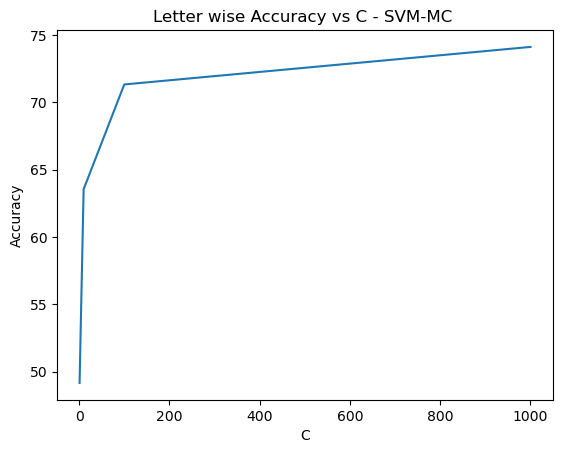

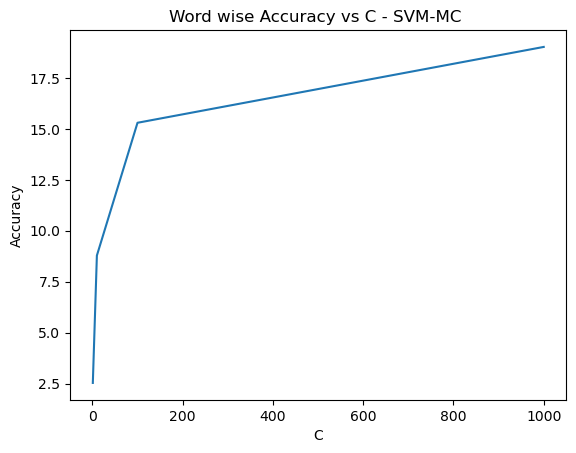

In [6]:
from sklearn.svm import LinearSVC
import matplotlib.pyplot as mp
import numpy as np

def train(xtrain,y_train,c):    
    clf = LinearSVC(random_state=0,C=c)
    clf.fit(xtrain,y_train)
    return clf

def test(model,X_test,y_test):
    y_pred=model.predict(X_test)
    score=(model.score(X_test,y_test))
    return y_test,y_pred,score

def form_words(y1,y2):
    word_ends=[]
    word_idx=read_word_indexes()
    word_ends=np.insert(np.where(word_idx==-1),0,0)
    given_words=[]
    pred_words=[] 
    start=0
    for i in range(len(word_ends)-1):   
        end=word_ends[i+1]+1
        g_word=y1[start:end]
        p_word=y2[start:end]
        g_word = [ i[0] for i in g_word ]
        start=end
        given_words.append(g_word)
        pred_words.append(p_word)
    return given_words, pred_words    
    
def word_accuracy(words1,words2):
    count=0
    for i,j in zip(words1,words2):
        if(np.array_equal(i,j)):
            count+=1
    return count/len(words1)
    
def plot():
    C=[1,10,100,1000]
    test_accuracy =[]
    word_acr =[]
    X_train ,y_train=read_train_struct();
    X_test,y_test=read_test_struct()

    for i in C : 
        y_train=y_train.ravel()
        clf=train(X_train,y_train,i/len(y_train))
        y_test,y_pred,score=test(clf,X_test,y_test)
        test_accuracy.append(score*100)
        y_train=y_train.reshape(len(y_train,))
        given_words, pred_words=form_words(y_test,y_pred)
        w_acc=word_accuracy(given_words,pred_words)
        word_acr.append(w_acc*100)
        
    mp.figure(1)
    mp.plot(C,test_accuracy)
    mp.ylabel('Accuracy')
    mp.xlabel('C')
    mp.title('Letter wise Accuracy vs C - SVM-MC ')
    mp.figure(2)
    mp.figure
    mp.plot(C,word_acr)
    mp.ylabel('Accuracy')
    mp.xlabel('C')
    mp.title('Word wise Accuracy vs C - SVM-MC ')

    
plot()

In [47]:
# Base path where your data resides, relative to your code directory
base_data_path = os.path.join("..", "data")

path = os.path.join(base_data_path, "decode_input.txt")
path1 = os.path.join(base_data_path, "train_struct.txt")
path2 = os.path.join(base_data_path, "train.txt")

print("Parameters x shape:", x.shape)
print("Parameters w shape:", w.shape)

def read_parameters():
    """
    Reads the parameters for the CRF model from the decode_input file.
    
    Returns:
        x (numpy.ndarray): Feature vectors of shape (100, 128).
        w (numpy.ndarray): Weight matrix for features of shape (26, 128).
        t (numpy.ndarray): Transition matrix of shape (26, 26).
    """
    # Load the raw data from the specified path
    raw_data = np.loadtxt(path, ndmin=1)
    # Extract and reshape the feature vectors, weight matrix, and transition matrix
    x = np.array(raw_data[0:100*128]).reshape(100, 128)
    w = np.array(raw_data[100*128:100*128+26*128]).reshape(26, 128)
    t = np.array(raw_data[100*128+26*128:]).reshape(26, 26)
    return x, w, t

def read_word_indexes():
    """
    Reads the word indexes from the train.txt file.
    
    Returns:
        numpy.ndarray: An array of word indexes.
    """
    # Load only the third column (word indexes) from the file
    raw_data = np.loadtxt(path2, usecols=(2,))
    return raw_data

def read_train_struct():
    """
    Reads training data structured for CRF model training.
    
    Returns:
        dataX (numpy.ndarray): Binary feature vectors for each example.
        dataY (numpy.ndarray): Labels for each example.
    """
    # Read raw data from the file
    with open(path1, "r") as f:
        raw_data = f.read().split("\n")

    dataX, dataY = [], []
    for line in raw_data[:-1]:  # Skip the last empty line
        line = line.split(" ")
        dataY.append([int(line[0])])  # Extract the label
        datax = [0]*128  # Initialize a binary feature vector
        for f1 in line[2:]:
            end = f1.find(":")
            datax[int(f1[:end])-1] = 1  # Set feature to 1 based on feature index
        dataX.append(datax)

    return np.array(dataX, dtype=float), np.array(dataY, dtype=int)

def read_test_struct():
    """
    Reads test data structured for CRF model testing.
    
    Returns:
        dataX (numpy.ndarray): Binary feature vectors for each example.
        dataY (numpy.ndarray): Labels for each example.
    """
    # Read raw data from the file
    with open(os.path.join(my_path, "data/test_struct.txt"), "r") as f:
        raw_data = f.read().split("\n")

    dataX, dataY = [], []
    for line in raw_data[:-1]:  # Skip the last empty line
        line = line.split(" ")
        dataY.append([int(line[0])])  # Extract the label
        datax = [0]*128  # Initialize a binary feature vector
        for f1 in line[2:]:
            end = f1.find(":")
            datax[int(f1[:end])-1] = 1  # Set feature to 1 based on feature index
        dataX.append(datax)

    return np.array(dataX, dtype=float), np.array(dataY, dtype=int)

# Debugging and verification
x, w, t = read_parameters()
print("Parameters x shape:", x.shape)
print("Parameters w shape:", w.shape)
print("Parameters t shape:", t.shape)

word_indexes = read_word_indexes()
print("Word indexes:", word_indexes)

train_dataX, train_dataY = read_train_struct()
print("Training dataX shape:", train_dataX.shape)
print("Training dataY shape:", train_dataY.shape)

test_dataX, test_dataY = read_test_struct()
print("Test dataX shape:", test_dataX.shape)
print("Test dataY shape:", test_dataY.shape)


Parameters x shape: (100, 128)
Parameters w shape: (26, 128)
Parameters x shape: (100, 128)
Parameters w shape: (26, 128)
Parameters t shape: (26, 26)
Word indexes: [ 2.  3. -1. ...  8.  9. -1.]
Training dataX shape: (25953, 128)
Training dataY shape: (25953, 1)
Test dataX shape: (26198, 128)
Test dataY shape: (26198, 1)


In [48]:
import subprocess
import matplotlib.pyplot as mp

def train(c):    
    output = subprocess.getoutput('svm_hmm_learn -c 1 train_struct.txt declaration.model')
    subprocess.call(["svm_hmm_learn", "-c", str(c), "train_struct.txt", "declaration.model"])

def test():
    output = subprocess.getoutput('svm_hmm_classify test_struct.txt declaration.model test.outtags ')
    subprocess.call(["svm_hmm_classify", "test_struct.txt", "declaration.model","test.outtags"])

def form_words(y1,y2):
    word_ends=[]
    word_idx=read_word_indexes()
    word_ends=np.insert(np.where(word_idx==-1),0,0)
    given_words=[]
    pred_words=[] 
    start=0
    for i in range(len(word_ends)-1):   
        end=word_ends[i+1]+1
        g_word=y1[start:end]
        p_word=y2[start:end]
        start=end
        given_words.append(g_word)
        pred_words.append(p_word)
    return given_words, pred_words    
    
def word_accuracy(words1,words2):
    count=0
    for i,j in zip(words1,words2):
        if(np.array_equal(i,j)):
            count+=1
    return count/len(words1)
    
def get_test_accuracy(y1,y2):
    count=0
    for i,j in zip(y1,y2):
        if(np.array_equal(i,j)):
            count+=1
    return count/len(y1)

    
def plot():
    C=[1,10, 100 , 1000]
    test_accuracy =[]
    word_acr =[]
    X_train ,y_train=read_train_struct();
    X_test,y_test=read_test_struct()
    for i in C : 
        train(i)
        test()
        path = os.path.join(base_data_path, "..", "code","test.outtags")
        y_pred=np.loadtxt(path,usecols=(0,))
        y_test=y_test.reshape(len(y_test),)
        test_acc=get_test_accuracy(y_test,y_pred)
        test_accuracy.append(test_acc*100)
        given_words, pred_words=form_words(y_test,y_pred)
        w_acc=word_accuracy(given_words,pred_words)
        word_acr.append(w_acc*100)
        
    mp.figure(1)
    mp.plot(C,test_accuracy)
    mp.ylabel('Accuracy')
    mp.xlabel('C')
    mp.title('Letter wise Accuracy vs C - SVM-hmm ')
    mp.figure(2)
    mp.plot(C,word_acr)
    mp.ylabel('Accuracy')
    mp.title('Word wise Accuracy vs C - SVM-hmm ')
    mp.xlabel('C')
    

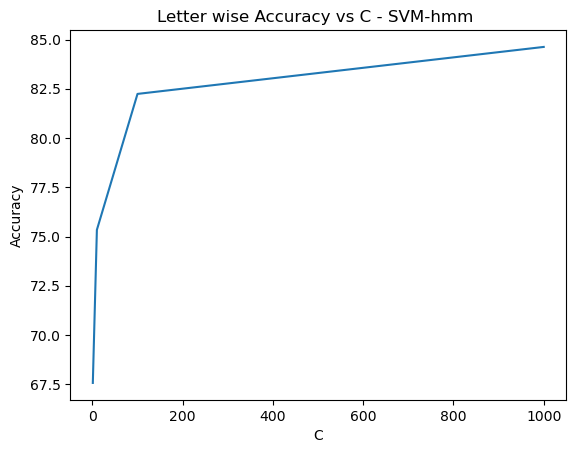

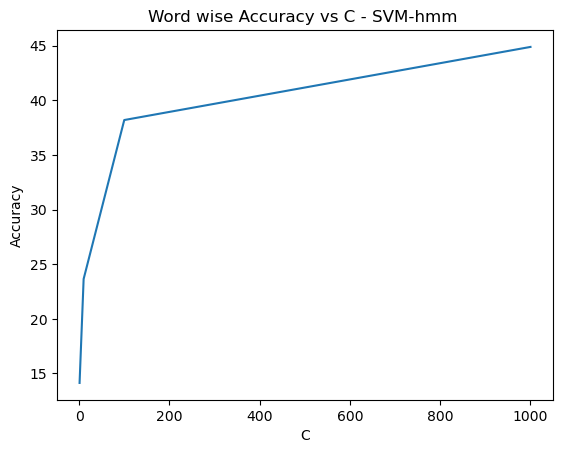

In [49]:
plot()

#SVM-hmm

In [35]:
def read_decode_input():
#function to read the data from decode_input
#100 letters each 128 elements
#26 weight vectors each 128 elements
#T which is a 26 x 26 weight matrix
#T is row major T_11, T_21, T_31 ..

	with open(decode_input_path, "r") as f:
		raw_data = f.read().split("\n")

	X = numpy.array(raw_data[:100*128], dtype=float).reshape(100,128)
	W = numpy.array(raw_data[100*128:100*128+26*128]\
		, dtype=float).reshape(26,128)
	T = numpy.array(raw_data[100*128+26*128:-1], dtype=float).reshape(26,26)
	T = numpy.swapaxes(T, 0, 1)

	return X, W, T


In [39]:
import itertools

def generate_mcombs(alphabet, m):
    """
    Generate all possible combinations of length m from the given alphabet.

    :param alphabet: List or array of possible elements.
    :param m: Length of the combinations to generate.
    :return: List of all combinations of the given length.
    """
    # Initialize a list to hold combinations
    combinations = [[]]
    for i in range(m): 
        # For each position in the combination, append all possible elements
        combinations = [j + [k] for k in alphabet for j in combinations]
    
    # Debug: print the number of combinations generated
    print(f"Generated {len(combinations)} combinations of length {m}")
    
    return combinations

def compute_prob(x, y, W, T):
    """
    Compute the score for a given sequence of observations x and label sequence y.

    :param x: Sequence of observations.
    :param y: Sequence of labels.
    :param W: Weight matrix.
    :param T: Transition matrix.
    :return: The score of the sequence.
    """
    # Initialize sums for features and transitions
    x_sum, t_sum = 0, 0
    # Calculate the score based on features and transitions
    for i in range(len(x) - 1):
        x_sum += np.dot(x[i, :], W[y[i], :])
        t_sum += T[y[i], y[i + 1]]
    # Add the score for the last observation
    x_sum += np.dot(x[len(x) - 1, :], W[y[len(x) - 1], :])

    return x_sum + t_sum


def find_max(x, combinations, W, T):
    """
    Find the most likely label sequence for a given observation sequence x.

    :param x: Sequence of observations.
    :param combinations: All possible label combinations.
    :param W: Weight matrix.
    :param T: Transition matrix.
    :return: The most likely label sequence and its corresponding score.
    """
    # Initialize the max score and corresponding label sequence
    max_val, likely_y = float('-inf'), None
    # Iterate through all combinations to find the best one
    for y in combinations:
        val = compute_prob(x, y, W, T)
        if max_val < val:
            max_val = val
            likely_y = y
    
    # Debug: print the most likely label sequence and its score
    print(f"Most likely sequence: {likely_y}, Score: {max_val}")
    
    return likely_y, max_val

def max_sum(X, W, T):
    """
    Decode the most likely label sequence for each observation sequence in X using the max-sum algorithm.

    :param X: Array of observation sequences.
    :param W: Weight matrix.
    :param T: Transition matrix.
    :return: Array of most likely label sequences for each observation sequence.
    """
    # Initialize the trellis for dynamic programming
    alpha_len = 26
    trellis = np.zeros((X.shape[0], alpha_len))
    interior = np.zeros(alpha_len)
    y_star = np.zeros(X.shape[0], dtype=int)

    # Fill in the trellis
    for i in range(1, X.shape[0]):
        for j in range(alpha_len):
            for k in range(alpha_len):
                interior[k] = np.dot(W[k], X[i - 1]) + T[k, j] + trellis[i - 1, k]
            trellis[i, j] = np.max(interior)

    # Backtrack to find the most likely sequence
    for i in range(alpha_len):
        interior[i] = np.dot(W[i], X[-1]) + trellis[-1, i]
    y_star[-1] = np.argmax(interior)

    for i in range(X.shape[0] - 1, 0, -1):
        for j in range(alpha_len):
            interior[j] = np.dot(W[j], X[i - 1]) + T[j, y_star[i]] + trellis[i - 1, j]
        y_star[i - 1] = np.argmax(interior)
    
    # Debug: print the final most likely label sequence
    print("Decoded sequence:", y_star)
    
    return y_star

In [45]:
from string import ascii_lowercase

X, W, T = read_decode_input()

y_star = max_sum(X, W, T)

#from string import ascii_lowercase
mapping = dict(enumerate(ascii_lowercase))

for i in range(y_star.shape[0]):
    print(mapping[y_star[i]])

def word_accuracy(words1,words2):
    count=0
    for i,j in zip(words1,words2):
        if(numpy.array_equal(i,j)):
            count+=1
    return count/len(words1)
    
def get_test_accuracy(y1,y2):
    count=0
    for i,j in zip(y1,y2):
        if(numpy.array_equal(i,j)):
            count+=1
    return count/len(y1)

def form_words(y1,y2):
    word_ends=[]
    
    word_idx=read_word_indexes()
    word_ends=numpy.insert(numpy.where(word_idx==-1),0,0)
    
    given_words=[]
    pred_words=[] 
    start=0
    
    for i in range(len(word_ends)-1):   
        end=word_ends[i+1]+1
        g_word=y1[start:end]
        p_word=y2[start:end]
        start=end
        given_words.append(g_word)
        pred_words.append(p_word)
    return given_words, pred_words 

# Check the decoder with the parameter calculated in 2(b)
def test_params(filepath):
    X_test,y_test=read_test_struct()
    y_pred=[]
    
    a=numpy.loadtxt(filepath, usecols=(0,))
    W=numpy.array(a[:26*128].reshape(26,128))
    T=numpy.array(a[26*128:26*128+26*26].reshape(26,26))
    
    y_pred = max_sum(X_test, W, T)
    y_pred=[y+1 for y in y_pred]
    y_test=y_test.reshape(25953,)
    numpy.savetxt("prediction",y_pred)
    
    #print(y_pred)
    #print(y_test)
    
    test_acc=get_test_accuracy(y_test,y_pred)
    test_accuracy=(test_acc*100)
    print("Test letter wise accuracy=",test_accuracy)
    
    y_test=y_test.reshape(len(y_test,))
    given_words, pred_words=form_words(y_test,y_pred)
    
    w_acc=word_accuracy(given_words,pred_words)
    word_acr =(w_acc*100)
    print("Test word accuracy=",word_acr)
    
    return word_acr, test_accuracy

w1t1 = os.path.join(base_data_path, "best_Weights_c1")
w2t2 = os.path.join(base_data_path, "best_Weights_c10")
w3t3 = os.path.join(base_data_path, "best_Weights_c100")
w4t4 = os.path.join(base_data_path, "..", "results", "Parameters")

#print(w1t1)

w1, t1 = test_params(w1t1)
w2, t2 = test_params(w2t2)
w3, t3 = test_params(w3t3)
w4, t4 = test_params(w4t4)
#w5, t5 = test_params("C:/Users/prana/Desktop/Fall 23/Adv ML/LAB1/code/best_Weights_c250")
#w6, t6 = test_params("C:/Users/prana/Desktop/Fall 23/Adv ML/LAB1/code/best_Weights_c500")
#w7, t7 = test_params("C:/Users/prana/Desktop/Fall 23/Adv ML/LAB1/code/best_Weights_c750")

Decoded sequence: [17 10 22  8 18 14 11 21 22  4 10 10 19  6 18 13  7 14  8  8  4  4 15  2
 20  5 19 20 20 21  3 25 10 20 10 17  0 15  4 20  1  8  4  4 16  2 25  9
 15  2 25 12 11  3 21  9 19 21 10 10 22 15 24  3 14 25 18  7 12  1 11  4
  9  2 11  0  7  0  2  7 19  3 15 19  5 19 12 13 16 23 16 19  7 11  0 10
 16  0 16 22]
r
k
w
i
s
o
l
v
w
e
k
k
t
g
s
n
h
o
i
i
e
e
p
c
u
f
t
u
u
v
d
z
k
u
k
r
a
p
e
u
b
i
e
e
q
c
z
j
p
c
z
m
l
d
v
j
t
v
k
k
w
p
y
d
o
z
s
h
m
b
l
e
j
c
l
a
h
a
c
h
t
d
p
t
f
t
m
n
q
x
q
t
h
l
a
k
q
a
q
w
Reading test structure from: ..\data\train_struct.txt
Decoded sequence: [13  4  4 ...  4 13  4]
Test letter wise accuracy= 44.64609101067314
Reading word indexes from: ..\data\train.txt
Test word accuracy= 0.9598603839441536
Reading test structure from: ..\data\train_struct.txt
Decoded sequence: [13 17  4 ...  4 13  4]
Test letter wise accuracy= 64.1043424652256
Reading word indexes from: ..\data\train.txt
Test word accuracy= 10.442117510180339
Reading test structure from

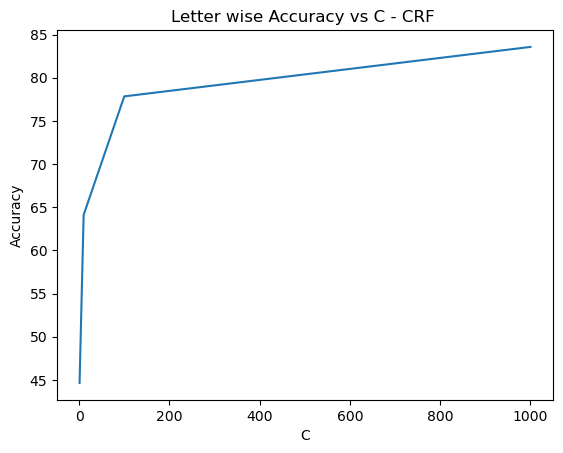

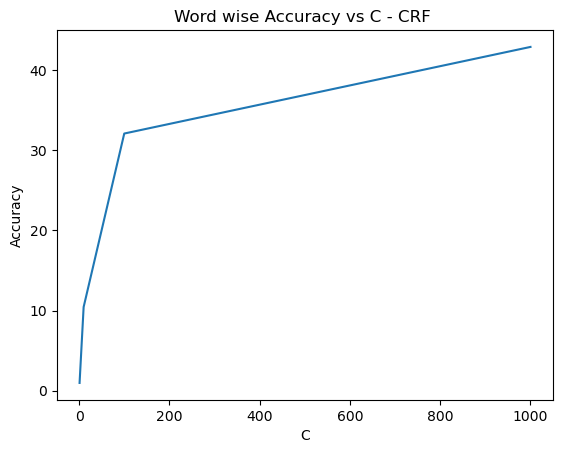

In [46]:


def plot():
    C=[1,10,100,1000]
    test_accuracy= [t1,t2,t3,t4]
    word_acr= [w1,w2,w3,w4]
    mp.figure(1)
    mp.plot(C,test_accuracy)
    mp.title('Letter wise Accuracy vs C - CRF ')
    mp.ylabel('Accuracy')
    mp.xlabel('C')
    mp.figure(2)
    mp.plot(C,word_acr)
    mp.ylabel('Accuracy')
    mp.xlabel('C')  
    mp.title('Word wise Accuracy vs C - CRF ')

plot()